KeyboardInterrupt: 

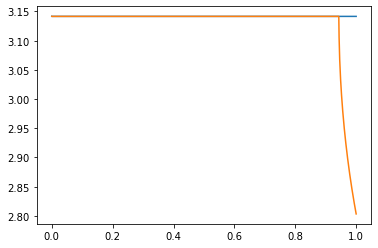

In [1]:
import numpy as np 
import scipy.optimize as sp 
import random
import matplotlib.pyplot as plt




def result(M:int,ni:float,parity:str):
    # Function to create the array of measurement parity 
    # M is the number of measurement 
    # ni is the failure rate 
    # Here we want negative parity to have a mean angle equal to pi 
    
    X = []
    
    if parity == 'pov' : 
        
        for i in range(int(M-ni*M)):
            X.append(0)
        for i in range (int(ni*M)):
            X.append(1)
            
    if parity == 'neg':
        
        for i in range(int(M-ni*M)):
            X.append(1)
        for i in range (int(ni*M)):
            X.append(0)

    return(np.array(X))

def Maximun_Likelihood(Y:float):
    # Maximun likelihood, Y is the linear function of Angle, V the visibility, X the parity measurement

    Dis_prob = (1 + ((-1)**X)*V*np.cos(Y))/(2)
    return(-np.sum(np.log(Dis_prob)))

N = 4

# Constant by which we multiply the failure to get the visibility
nb_F = np.linspace(0.00001,1,num=1000)

# Failure probability
nb_X = np.linspace(0.0001,0.49,num=10)

for j in range(len(nb_X)):
    X = result(1000,nb_X[j],'neg')
    random.shuffle(X)
    results = []

    for i in range(len(nb_F)):
        V = (nb_F[i])*(1-nb_X[j])
        Y_init = 1
        results.append(sp.minimize(Maximun_Likelihood,Y_init).x)
    plt.plot(nb_F,results,label = nb_X[j])

plt.legend(title = 'Failure rate')
plt.xlabel('Constant we should multply the failure rate')
plt.ylabel('Angle should')

In [ ]:
# Function to simulate the noise and apply it to a density matrix

import numpy as np
import itertools
import scipy as scipy

def depolarising_Kraus_operators(d, eta, verify:bool=False):
    # Nielsen & Chuang, page 378.
    '''
    Parameters
    ----------
    d : int
        Number of parameters.
    eta : float
        noise parameter:
            eta=1: pure state and no noise,
            eta=0: only noise, the state is lost completely.
    verify : bool, optional
        Verification for the Kraus operators. The default is False.

    Returns
    -------
    K : TYPE
        List of amplitude damping Kraus operators.
    '''
    
    a = np.sqrt(1-3*eta/4)
    b = np.sqrt(eta/4)
    
    K_A = a * np.array([[1, 0], [0, 1]])
    K_B = b * np.array([[0, 1], [1, 0]])
    K_C = b * np.array([[0, -1j], [1j, 0]])
    K_D = b * np.array([[1, 0], [0, -1]])
    
    lists = list(itertools.product([K_A, K_B, K_C, K_D], repeat=d))
    
    K = []
    for i in range(len(lists)):
        k = np.array([1])
        for j in range(len(lists[i])):
            k = np.kron(k, lists[i][j])
        
        K.append(k)
        
    if verify:
        verify_K(K)
    
    return K


def dephasing_Kraus_operators(d, eta, verify:bool=False):
    # Majid
    
    K_A = np.sqrt((1-eta)) * np.array([[1, 0], [0, 1]])
    K_B = np.sqrt(eta) * np.array([[1, 0], [0, -1]])
    
    lists = list(itertools.product([K_A, K_B], repeat=d))
    
    K = []
    for i in range(len(lists)):
        k = np.array([1])
        for j in range(len(lists[i])):
            k = np.kron(k, lists[i][j])
        
        K.append(k)
        
    if verify:
        verify_K(K)
    
    return K

def amplitude_damping_Kraus_operators(d:int, eta:float, verify:bool=False):
    # Nielsen & Chuang, page 380.
    '''
    Parameters
    ----------
    d : int
        Number of parameters.
    eta : float
        noise parameter:
            eta=1: pure state and no noise,
            eta=0: only noise, the state is lost completely.
    verify : bool, optional
        Verification for the Kraus operators. The default is False.

    Returns
    -------
    K : list
        List of amplitude damping Kraus operators.
    '''
    
    K_A = np.array([[1, 0], [0, np.sqrt(1-eta)]])
    K_B = np.array([[0, np.sqrt(eta)], [0, 0]])
    
    lists = list(itertools.product([K_A, K_B], repeat=d))
    
    K = []
    for i in range(len(lists)):
        k = np.array([1])
        for j in range(len(lists[i])):
            k = np.kron(k, lists[i][j])
        
        K.append(k)
    
    if verify:
        verify_K(K)
    
    return K

def phase_damping_Kraus_operators(d:int, eta:float, verify:bool=False):
    # Nielsen & Chuang, page 383.
    '''
    Parameters
    ----------
    d : int
        Number of parameters.
    eta : float
        noise parameter:
            eta=1: pure state and no noise,
            eta=0: only noise, the state is lost completely.
    verify : bool, optional
        Verification for the Kraus operators. The default is False.

    Returns
    -------
    K : list
        List of phase damping Kraus operators.
    '''
    
    K_A = np.array([[1, 0], [0, np.sqrt(1-eta)]])
    K_B = np.array([[0, 0], [0, np.sqrt(eta)]])
    
    lists = list(itertools.product([K_A, K_B], repeat=d))
    
    K = []
    for i in range(len(lists)):
        k = np.array([1])
        for j in range(len(lists[i])):
            k = np.kron(k, lists[i][j])
        
        K.append(k)
    
    if verify:
        verify_K(K)
    
    return K

def verify_K(K:list, d:int,Nb_noise:int, verbose:bool=True):
    '''
    Parameters
    ----------
    K : list
        List of Kraus operators.
    d : int
        Dimension (i.e. number of parameters).
    verbose : bool, optional
        If True, it prints the result of the matrix multiplication of (K^t)*K,
        which should be the dxd identity matrix.
        The default is False.

    Returns
    -------
    bool
    True, if the Kraus operators are well defined.
    False, otherwise.
    '''
    
    s = np.zeros((2**d, 2**d))
    print('')
    for j in range(Nb_noise):
        for i in range(len(K[j])):
            s = s + np.matmul(np.conjugate(np.transpose(K[j][i])), K[j][i])
            
            #print(i, s) # to print step by step.
    if verbose:
        print('\nVerification:\n', np.real(s/4), '\n', 50*'-')
        

def apply_noise(rho, d:int, K:list, Nb_noise:int):
    '''
    Parameters
    ----------
    rho : Numpy 2d-array
        Density matrix of the state to apply .
    d : int
        dimension.
    K : list
        List of Kraus operators.
    Nb_noise : int
        Number of type of noise you want to apply

    Returns
    -------
    s : Numpy 2d-array
        Density matrix after noise.
    '''
    verify_K(K,d,Nb_noise)
    for j in range(Nb_noise):
        s = np.zeros((2**d, 2**d))
        for i in range(len(K[j])):
            s = s + np.matmul(np.matmul(K[j][i], rho), np.conjugate(np.transpose(K[j][i])))
        rho = s
    s = s
    return s

def fid(dm, target):
    '''
    Parameters
    ----------
    dm : Numpy 2d-array
        Density matrix of the state yoi have .
    dm : Numpy 2d-array
        Density matrix of the state you want .
    Returns
    -------
    the fidelidy calculate in different ways if the shape of your matrice is not the same as your target
    '''
    shape=np.shape(target)

    if (len(shape)>1):
        return (np.trace(scipy.linalg.sqrtm(scipy.linalg.sqrtm(target)@dm@scipy.linalg.sqrtm(target))))**2/(np.trace(target)*np.trace(dm))
    else:
        return np.transpose(np.conjugate(target))@dm@target
    

In [ ]:
#### Linking the failure rate to the visibility ####
import numpy as np 
import scipy.optimize as sp
import functools as ft 


sigma_x = np.array([[0,1],[1,0]])
sigma_z = np.matrix([[1,0],[0,-1]])
sigma_y = np.matrix([[0,-1j],[1j,0]])
Id = np.matrix([[1,0],[0,1]])
Id_8 = np.identity(16)

# GHZ state
bell=(np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])+np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]))/np.sqrt(2)
rho = (np.array(np.outer(bell, np.transpose(np.conjugate(bell)))))

# Measurement list
List_of_Meas = [ft.reduce(np.kron,(sigma_x,sigma_x,sigma_x,sigma_x)),-ft.reduce(np.kron,(sigma_y,sigma_y,sigma_x,sigma_x)),
                -ft.reduce(np.kron,(sigma_x,sigma_y,sigma_y,sigma_x)),-ft.reduce(np.kron,(sigma_x,sigma_x,sigma_y,sigma_y)),
                -ft.reduce(np.kron,(sigma_y,sigma_x,sigma_x,sigma_y))]

# Type of Noise
phase_damping = phase_damping_Kraus_operators(4,0)
amplitude_damping = amplitude_damping_Kraus_operators(4,0)
depolarising = depolarising_Kraus_operators(4,0.01)
dephasing = dephasing_Kraus_operators(4,0.01)
Noise = [phase_damping,amplitude_damping,depolarising,dephasing]

# Noisy GHZ state
Rho_Noise = apply_noise(rho, 4, Noise, 4)

# Failure rate
F = 1 - 1/5*(np.sum([np.trace(Rho_Noise@List_of_Meas[i]) for i in range(len(List_of_Meas))]))
print('Failure rate = ', np.real(F))

# Fidelity 
Fidelity = fid(Rho_Noise,rho)
print('Fidelity = ',np.real(Fidelity))


In [3]:
#### Linking the failure rate to the visibility ####
import numpy as np 
import scipy.optimize as sp
import functools as ft 
import QPE_Noise as qp_n


sigma_x = np.array([[0,1],[1,0]])
sigma_z = np.matrix([[1,0],[0,-1]])
sigma_y = np.matrix([[0,-1j],[1j,0]])
Id = np.matrix([[1,0],[0,1]])
Id_8 = np.identity(16)

# GHZ state
bell=(np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])+np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]))/np.sqrt(2)
rho = (np.array(np.outer(bell, np.transpose(np.conjugate(bell)))))
noise = qp_n.Noise(rho)


# Measurement list
List_of_Meas = [ft.reduce(np.kron,(sigma_x,sigma_x,sigma_x,sigma_x)),-ft.reduce(np.kron,(sigma_y,sigma_y,sigma_x,sigma_x)),
                -ft.reduce(np.kron,(sigma_x,sigma_y,sigma_y,sigma_x)),-ft.reduce(np.kron,(sigma_x,sigma_x,sigma_y,sigma_y)),
                -ft.reduce(np.kron,(sigma_y,sigma_x,sigma_x,sigma_y))]

# Type of Noise
phase_damping = noise.phase_damping_Kraus_operators(0)
amplitude_damping = noise.amplitude_damping_Kraus_operators(0)
depolarising = noise.depolarising_Kraus_operators(0.01)
dephasing = noise.dephasing_Kraus_operators(0.01)
Noise_type = [phase_damping,amplitude_damping,depolarising,dephasing]

noise.verify_K(Noise_type,4)

# Noisy GHZ state
Rho_Noise = qp_n.apply_noise(noise.state, 4,Noise_type, 4)

# Failure rate
F = 1 - 1/5*(np.sum([np.trace(Rho_Noise@List_of_Meas[i]) for i in range(len(List_of_Meas))]))
print('Failure rate = ', np.real(F))

# Fidelity 
Fidelity = qp_n.fid(Rho_Noise,rho)
print('Fidelity = ',np.real(Fidelity))




Verification:
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]] 
 --------------------------------------------------
Failure rate =  0.11397682575295831
Fidelity =  0.93308633774852


<string>:53: SyntaxWarning: invalid escape sequence '\{'
<>:53: SyntaxWarning: invalid escape sequence '\{'
<string>:53: SyntaxWarning: invalid escape sequence '\{'
<>:53: SyntaxWarning: invalid escape sequence '\{'
C:\Users\Experience\AppData\Local\Temp\ipykernel_26164\2446480580.py:53: SyntaxWarning: invalid escape sequence '\{'
  os.chdir(f'{working_dir_data}\{file}')


1134.0
1048.0
933.0
968.0
1235.0
859.0


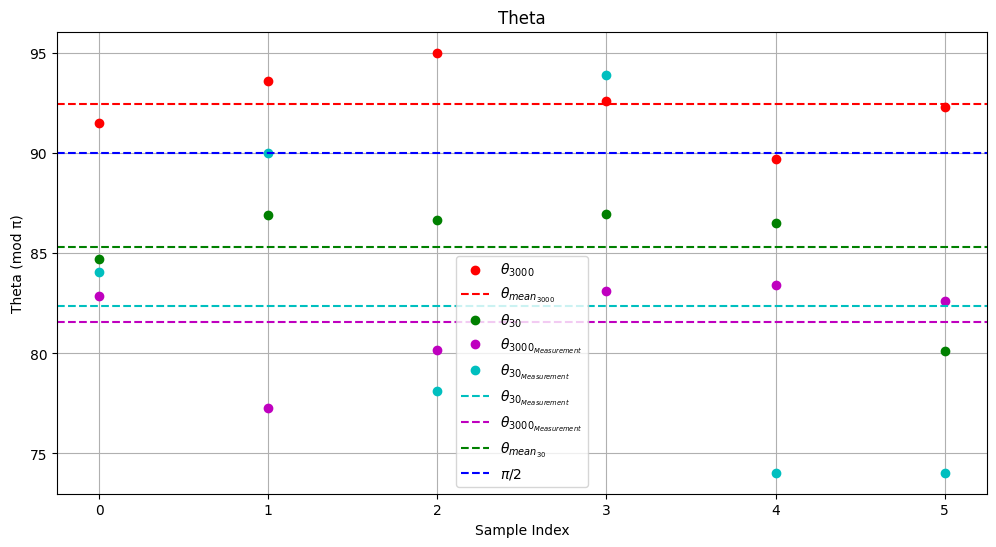

In [ ]:
############## FINAL ANGLE PLOT ################
import numpy as np 
import scipy.optimize as sp
import functools as ft 
import QPE_Noise as qp_n
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import QPE_Function as qpef
import glob
import os

def generate_angles_in_radians():
    """
    Génère 4 angles en radians dont la somme est un multiple de π,
    avec les trois premiers angles générés aléatoirement.
    """
    # Générer aléatoirement trois angles dans l'intervalle [0, π)
    angles = [np.random.uniform(0, 2*np.pi) for _ in range(3)]
    
    # Calculer le quatrième angle pour que la somme soit un multiple de π
    total = sum(angles)
    remainder = total % np.pi
    fourth_angle = (np.pi - remainder) if remainder != 0 else 0

    # S'assurer que le quatrième angle est dans l'intervalle [0, π)
    if fourth_angle <= 0 or fourth_angle >= np.pi:
        return generate_angles_in_radians()

    angles.append(fourth_angle)
    return angles

def Maximun_Likelihood_Matrix(Theta, frequency, RHO) :
    
    sigma_x = (1/np.sqrt(2))*np.matrix([[1,1],[1,-1]])
    Rho_Theta = np.array(ft.reduce(np.kron,(sigma_x,sigma_x,sigma_x,sigma_x))@qp_n.apply_angle(RHO,Theta)@ft.reduce(np.kron,(sigma_x,sigma_x,sigma_x,sigma_x)))
    Dis_prob =  Rho_Theta.diagonal()*frequency

    return(-sum(np.log(Dis_prob,out=np.zeros_like(Dis_prob, dtype=np.complex128), where=(Dis_prob!=0))))

counts = []
density_matrix_30 = []
density_matrix_3000 = []

working_dir_data = r"C:\Users\Experience\Desktop\Multipartite Entanglement Experiment\Data\QST"

filenames = [['QST_GHZ_aqtime=100.0s_20241221110125','QST_GHZ_aqtime=100.0s_20241226090240','QST_GHZ_aqtime=100.0s_20241229140510','QST_GHZ_aqtime=100.0s_20250101203050','QST_GHZ_aqtime=100.0s_20250108191319','QST_GHZ_aqtime=100.0s_20250110223506']
             ,['QST_GHZ_aqtime=100.0s_20241217192503','QST_GHZ_aqtime=100.0s_20241221110125','QST_GHZ_aqtime=100.0s_20241226090240','QST_GHZ_aqtime=100.0s_20250101203050','QST_GHZ_aqtime=100.0s_20250106105201','QST_GHZ_aqtime=100.0s_20250110223506']]

plt.figure(figsize= (12,6))

for index, file in enumerate(filenames[1]):
    os.chdir(f'{working_dir_data}\{file}')
    with open('density.npy','rb') as f:
        density_matrix_30.append(np.load(f))

for index, file in enumerate(filenames[0]):
    os.chdir(f'{working_dir_data}//{file}')
    with open('density.npy','rb') as f:
        density_matrix_3000.append(np.load(f))


working_dir_data = r"C:\Users\Experience\Desktop\Multipartite Entanglement Experiment\Data\Phase_stats"
filenames = ["COMPLETE_QPE_FIRST_RUN_20241221183632","COMPLETE_QPE_SECOND_RUN_202412261154","COMPLETE_QPE_THIRD_RUN_20241229165806","COMPLETE_QPE_FOURTH_RUN_20250101232850","COMPLETE_QPE_FIFTH_RUN_20250108030226","COMPLETE_QPE_SIXTH_RUN_20250114015928"]
os.chdir(working_dir_data)
        
counts_array = []
counts_array_list = []

minu = [1134,1048,933,968,1235,859]

for index, file in enumerate(filenames):
        os.chdir(f'{working_dir_data}\\{file}\\counts')
        fi = [i for i in glob.glob("Phase*")]
        counts_array = []
        for files in fi[:minu[index]] :
            with open(files) as file:
                for line in file:
                    counts.append(line.split())
                    counts_array.append(np.array(counts[-1][:16], dtype=float))
        counts_array_list.append(counts_array)
    
final_angle =[]
Y_init = []

for i in range(300):
    Y_init.append(generate_angles_in_radians())

for i in range(len(filenames)):
    angle = []
    Min = []
    Rho_Exp = density_matrix_3000[i]
    frequency = sum(counts_array_list[i])
    print(sum(frequency))
    for z in range(len(Y_init)):
        solution = sp.minimize(Maximun_Likelihood_Matrix,np.real(Y_init[z]),args=(frequency,Rho_Exp), method = 'SLSQP',tol=1e-8,options={'maxiter' : 10000000})
        angle.append(np.real(sum(solution.x))%np.pi)
        Min.append(solution.fun)
    final_angle.append(angle[Min.index(min(Min))]*180/np.pi)
final_angle_mean = np.mean(final_angle)
# Set figure size for better readability
plt.plot(np.array(final_angle),'o', label=r'$\theta_{3000}$',color = 'r')
plt.axhline(final_angle_mean,color = 'r',linestyle='--',label = r'$\theta_{mean_{3000}}$')

counts = []
final_angle =[]
counts_array = []
counts_array_list = []

working_dir_data = r'C:\Users\Experience\Desktop\Multipartite Entanglement Experiment\Data\Private_Quantum_Sensing'
os.chdir(working_dir_data)
filenames = ["COMPLETE_QPE_FIRST_RUN","COMPLETE_QPE_SECOND_RUN","COMPLETE_QPE_THIRD_RUN","COMPLETE_QPE_FOURTH_RUN","COMPLETE_QPE_FIFTH_RUNS","COMPLETE_QPE_SIXTH_RUN"]

for index, file in enumerate(filenames):
        os.chdir(f'{working_dir_data}\\{file}\\counts')
        fi = [i for i in glob.glob("Phase*")]
        counts_array = []
        for files in fi :
            with open(files) as file:
                for line in file:
                    counts.append(line.split())
                    counts_array.append(np.array(counts[-1][:16], dtype=float))
        counts_array_list.append(counts_array)

for i in range(len(filenames)):
    angle = []
    Min = []
    Rho_Exp = density_matrix_30[i]
    frequency = sum(counts_array_list[i])
    #print(np.real(sum(sp.minimize(Maximun_Likelihood_Matrix,Y_init,args=(frequency,Rho_Exp), method = 'Powell',tol=1e-10,options={'maxiter' : 10000000}).x))% np.pi)
    for z in range(len(Y_init)):
        solution = sp.minimize(Maximun_Likelihood_Matrix,Y_init[z],args=(frequency,Rho_Exp), method = 'SLSQP',tol=1e-8,options={'maxiter' : 10000000})
        angle.append(np.real(sum(solution.x))%np.pi)
        Min.append(solution.fun)
    final_angle.append(angle[Min.index(min(Min))]*180/np.pi)
final_angle_mean = np.mean(final_angle)


# Set figure size for better readability


plt.plot(np.array(final_angle), 'o',label=r'$\theta_{30}$',color = 'g')

plt.plot(np.array([1.44654388, 1.3489827 , 1.39899048, 1.45114583, 1.45636136,
       1.44163514])*180/np.pi,'o',label = r'$\theta_{3000_{Measurement}}$',color = 'm' )
plt.plot(np.array([1.46740602, 1.57079633, 1.36309533, 1.63951867, 1.29222542,
       1.29222542])*180/np.pi,'o',label = r'$\theta_{30_{Measurement}}$' ,color = 'c')

plt.axhline(np.mean([1.46740602, 1.57079633, 1.36309533, 1.63951867, 1.29222542,
       1.29222542])*180/np.pi,color = 'c',linestyle='--',label = r'$\theta_{30_{Measurement}}$')
plt.axhline(np.mean([1.44654388, 1.3489827 , 1.39899048, 1.45114583, 1.45636136,
       1.44163514])*180/np.pi,color = 'm',linestyle='--',label = r'$\theta_{3000_{Measurement}}$')

# Add labels, legend, and title
plt.axhline(final_angle_mean,color = 'g',linestyle='--',label = r'$\theta_{mean_{30}}$')
plt.axhline(np.pi/2*180/np.pi, color='b', linestyle='--', label=r"$\pi/2$")
plt.xlabel("Sample Index")
plt.ylabel("Theta (mod π)")
plt.title("Theta")
plt.legend()
plt.grid(True)  # Add grid for better readability

plt.show()

